In [109]:
import spacy

# Load pre-trained spaCy model for text processing
nlp = spacy.load("en_core_web_sm")

# COCO categories for object detection
coco_categories = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
    'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle',
    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Function to extract object classes from text
def extract_object_classes_from_text(text):
    doc = nlp(text)
    object_classes = set()

    for np in doc.noun_chunks:
        np_text = np.text.strip().lower()
        np_text = np_text.replace('a ', '').replace('the ', '')  # Clean articles
        for coco_class in coco_categories:
            if coco_class in np_text:
                object_classes.add(coco_class)
    return object_classes

# Example input text
text_input = """
Birds were flying near a car while a person was walking on the street.
"""

# Extract object classes from the text
detected_classes = extract_object_classes_from_text(text_input)

# Display the detected object classes
print("Detected Object Classes:", detected_classes)


Detected Object Classes: {'car', 'person', 'bird'}


loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


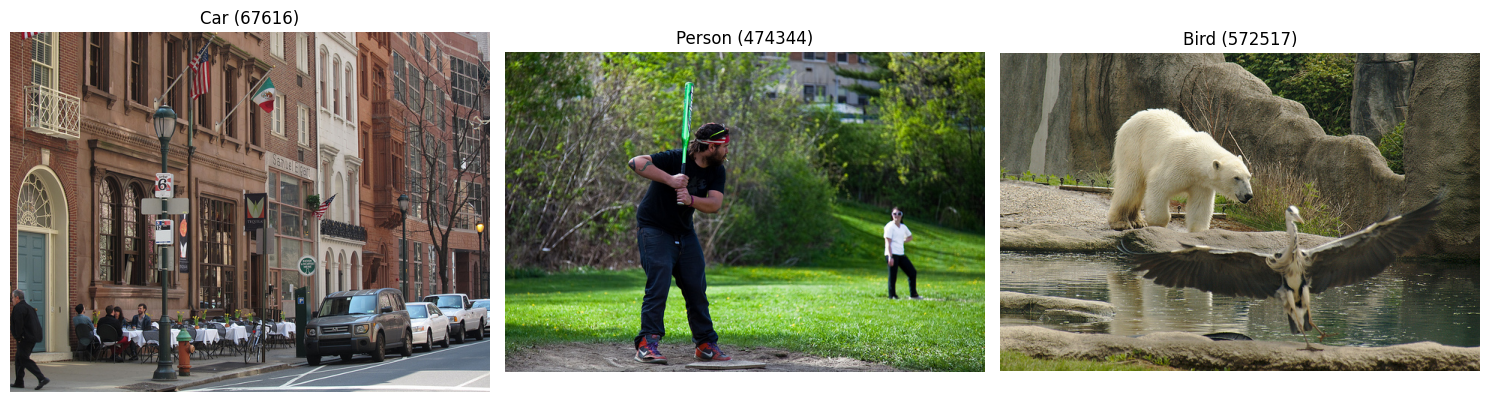

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Extracted features from retrieved images.


In [138]:
# Cell 2 - Use ResNet50 for feature extraction

import os
import random
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# Load ResNet50 model (pre-trained)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Paths to dataset and annotations
DATASET_PATH = "C:/Users/Lenovo/OneDrive/Desktop/DL-PRO/coco_dataset/val2017"
ANNOTATIONS_PATH = "C:/Users/Lenovo/OneDrive/Desktop/DL-PRO/coco_annotations/annotations/instances_val2017.json"

# Load COCO dataset
coco = COCO(ANNOTATIONS_PATH)

# Function to preprocess and extract features from an image
def preprocess_and_extract(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224)) / 255.0  # Resize and normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    features = feature_extractor.predict(image)
    return features.reshape(-1)

# Function to get image IDs containing the given object names
def display_images_for_classes(classes, coco_instance, dataset_path):
    image_paths = []
    images_displayed = 0
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))  # One image per detected class

    # Handle cases where there's only one class (axes won't be iterable)
    if len(classes) == 1:
        axes = [axes]

    for i, obj_class in enumerate(classes):
        # Get COCO category ID for the class
        cat_ids = coco_instance.getCatIds(catNms=[obj_class])
        if not cat_ids:
            print(f"Class '{obj_class}' not found in COCO dataset. Skipping...")
            continue

        # Get all image IDs containing the class
        img_ids = coco_instance.getImgIds(catIds=cat_ids)
        if not img_ids:
            print(f"No images found for class '{obj_class}'. Skipping...")
            continue

        # Select a random image ID
        img_id = random.choice(img_ids)
        img_data = coco_instance.loadImgs(img_id)[0]
        img_path = os.path.join(dataset_path, img_data['file_name'])
        image_paths.append(img_path)  # Save the image path for later use

        try:
            # Load the image
            img = Image.open(img_path).convert("RGB")
            axes[images_displayed].imshow(img)
            axes[images_displayed].axis('off')
            axes[images_displayed].set_title(f"{obj_class.capitalize()} ({img_id})")
            images_displayed += 1
        except Exception as e:
            print(f"Error displaying image for class '{obj_class}': {e}")

        # Stop if we've displayed all allocated axes
        if images_displayed >= len(axes):
            break
    
    if images_displayed > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("No images to display.")
    
    return image_paths

# Use the detected classes from Cell 1
detected_classes = list(detected_classes)  # Example: Replace `detected_classes` with actual values from Cell 1

# Display images for the detected classes and return image paths
image_paths = display_images_for_classes(detected_classes, coco, DATASET_PATH)

# Extract features for all retrieved images
features_list = [preprocess_and_extract(path) for path in image_paths]
print("Extracted features from retrieved images.")


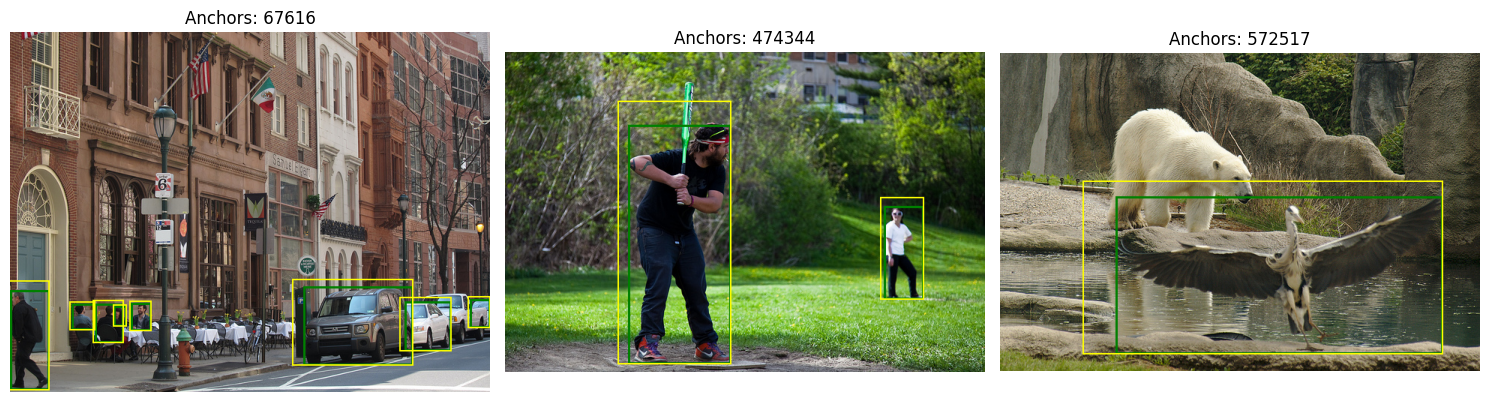

In [139]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Function to generate and display anchors for detected objects
def visualize_anchors_for_detected_objects(image_paths, detected_classes, coco_instance, anchor_factor=0.1):
    """
    Visualize positive and negative anchors for detected objects.
    
    Parameters:
    - image_paths: List of image file paths
    - detected_classes: List of detected object classes
    - coco_instance: COCO dataset instance
    - anchor_factor: Factor to expand/contract bounding boxes for negative anchors
    """
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

    if len(image_paths) == 1:
        axes = [axes]  # Handle single image case

    images_displayed = 0
    for img_path in image_paths:
        try:
            # Load the image
            img = Image.open(img_path).convert("RGB")
            draw = ImageDraw.Draw(img)

            # Extract the image ID from the path
            img_id = int(os.path.splitext(os.path.basename(img_path))[0].split('_')[-1])

            # Get annotations for the image
            ann_ids = coco_instance.getAnnIds(imgIds=[img_id])
            anns = coco_instance.loadAnns(ann_ids)

            positive_anchors = []  # List for positive anchors
            negative_anchors = []  # List for negative anchors

            for ann in anns:
                category_name = coco_instance.loadCats([ann['category_id']])[0]['name']
                if category_name in detected_classes:  # Process only detected classes
                    bbox = ann['bbox']  # Original bounding box
                    x, y, w, h = bbox

                    # Generate positive and negative anchors
                    positive_anchors.append((x, y, w, h))  # Positive anchor is the original bbox
                    negative_anchors.append((
                        x - w * anchor_factor, 
                        y - h * anchor_factor, 
                        w * (1 + anchor_factor), 
                        h * (1 + anchor_factor)
                    ))

            # Draw positive anchors (green)
            for x, y, w, h in positive_anchors:
                draw.rectangle([x, y, x + w, y + h], outline="green", width=3)  # Green for positive anchors

            # Draw negative anchors (yellow)
            for x, y, w, h in negative_anchors:
                draw.rectangle([x, y, x + w, y + h], outline="yellow", width=2)  # Yellow for negative anchors

            # Display the annotated image
            axes[images_displayed].imshow(img)
            axes[images_displayed].axis('off')
            axes[images_displayed].set_title(f"Anchors: {img_id}")
            images_displayed += 1

        except Exception as e:
            print(f"Error visualizing anchors for image {img_path}: {e}")

        # Stop if we've displayed all allocated axes
        if images_displayed >= len(axes):
            break

    if images_displayed > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("No images to display.")

# Visualize anchors for the retrieved images
visualize_anchors_for_detected_objects(image_paths, detected_classes, coco)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image ID: 67616
  Bounding Box 1:
    Original: (x: 391.31, y: 339.93, w: 145.9, h: 104.56)
    Refined:  (x: 403.59547059893606, y: 341.7274652814865, w: 160.67464043423533, h: 113.57731293439865)
  Bounding Box 2:
    Original: (x: 613.07, y: 356.06, w: 26.93, h: 38.1)
    Refined:  (x: 616.2437772975862, y: 356.69036008309575, w: 30.543832021951676, h: 42.01416538059711)
  Bounding Box 3:
    Original: (x: 0.04, y: 344.49, w: 52.7, h: 133.5)
    Refined:  (x: 1.8469049771875143, y: 349.6047314775735, w: 56.098494495451455, h: 142.3485639989376)
  Bounding Box 4:
    Original: (x: 113.82, y: 362.99, w: 37.65, h: 51.56)
    Refined:  (x: 116.5690323074162, y: 364.54360416054726, w: 40.8

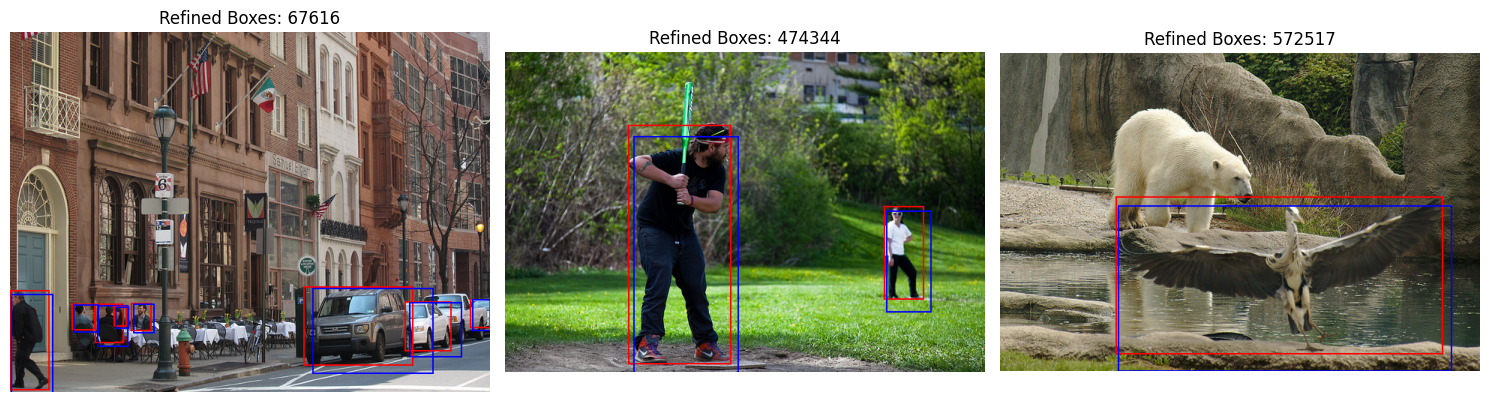

In [156]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Function to refine bounding boxes
def refine_bounding_boxes_with_model(detected_boxes, refinement_model):
    """
    Refine bounding boxes using a trained model.

    Parameters:
    - detected_boxes: List of original bounding boxes (x, y, width, height).
    - refinement_model: A pre-trained or lightweight regression model.

    Returns:
    - refined_boxes: List of refined bounding boxes.
    """
    refined_boxes = []

    for box in detected_boxes:
        # Normalize bounding box coordinates and dimensions
        x, y, w, h = box
        normalized_box = np.array([x / 512, y / 512, w / 512, h / 512]).reshape(1, -1)

        # Predict refinement values using the model
        delta = refinement_model.predict(normalized_box)[0]

        # Apply refinements to the bounding box
        refined_x = x + delta[0] * w
        refined_y = y + delta[1] * h
        refined_w = w * (1 + delta[2])
        refined_h = h * (1 + delta[3])

        refined_boxes.append((refined_x, refined_y, refined_w, refined_h))

    return refined_boxes

# Lightweight model for bounding box refinement
def create_refinement_model():
    """
    Create a simple regression model for bounding box refinement.

    Outputs:
    - A lightweight neural network model.
    """
    model = Sequential([
        Dense(32, activation='relu', input_shape=(4,)),
        Dense(16, activation='relu'),
        Dense(4, activation='linear')  # Outputs: delta_x, delta_y, delta_w, delta_h
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to visualize refined bounding boxes
def display_refined_bounding_boxes(image_paths, detected_classes, coco_instance, refinement_model):
    """
    Display refined bounding boxes for detected objects.

    Parameters:
    - image_paths: List of image file paths
    - detected_classes: List of detected object classes
    - coco_instance: COCO dataset instance
    - refinement_model: A model to predict bounding box refinements
    """
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

    if len(image_paths) == 1:
        axes = [axes]  # Handle single image case

    images_displayed = 0
    for img_path in image_paths:
        try:
            # Load the image
            img = Image.open(img_path).convert("RGB")
            draw = ImageDraw.Draw(img)

            # Extract the image ID from the path
            img_id = int(os.path.splitext(os.path.basename(img_path))[0].split('_')[-1])

            # Get annotations for the image
            ann_ids = coco_instance.getAnnIds(imgIds=[img_id])
            anns = coco_instance.loadAnns(ann_ids)

            detected_boxes = []
            for ann in anns:
                category_name = coco_instance.loadCats([ann['category_id']])[0]['name']
                if category_name in detected_classes:
                    detected_boxes.append(ann['bbox'])  # Add original bounding box

            # Refine bounding boxes using the model
            refined_boxes = refine_bounding_boxes_with_model(detected_boxes, refinement_model)

            # Draw original and refined bounding boxes
            for (orig_box, refined_box) in zip(detected_boxes, refined_boxes):
                x, y, w, h = orig_box
                draw.rectangle([x, y, x + w, y + h], outline="red", width=2)  # Original bbox (red)
                refined_x, refined_y, refined_w, refined_h = refined_box
                draw.rectangle([refined_x, refined_y, refined_x + refined_w, refined_y + refined_h], outline="blue", width=2)  # Refined bbox (blue)

            # Display the image
            axes[images_displayed].imshow(img)
            axes[images_displayed].axis('off')
            axes[images_displayed].set_title(f"Refined Boxes: {img_id}")
            images_displayed += 1

            # Display the bounding box values after the image
            print(f"Image ID: {img_id}")
            for i, (orig_box, refined_box) in enumerate(zip(detected_boxes, refined_boxes)):
                x, y, w, h = orig_box
                refined_x, refined_y, refined_w, refined_h = refined_box
                print(f"  Bounding Box {i+1}:")
                print(f"    Original: (x: {x}, y: {y}, w: {w}, h: {h})")
                print(f"    Refined:  (x: {refined_x}, y: {refined_y}, w: {refined_w}, h: {refined_h})")
            print()  # Empty line for separation

        except Exception as e:
            print(f"Error processing image: {e}")

    if images_displayed > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("No images to display.")

# Create and train the refinement model (use dummy data for illustration purposes)
refinement_model = create_refinement_model()
dummy_data = np.random.rand(100, 4)  # 100 samples of (x, y, w, h)
dummy_labels = np.random.rand(100, 4) * 0.1  # 10% perturbations
refinement_model.fit(dummy_data, dummy_labels, epochs=10, verbose=0)


# Display refined bounding boxes
display_refined_bounding_boxes(image_paths, detected_classes, coco, refinement_model)


In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(224, 224, 3)):
    inputs = layers.Input(input_size)
    
    # Contracting path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottom (Bottleneck)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding path (Decoder)
    u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Sigmoid for binary segmentation

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create U-Net model
unet_model_instance = unet_model()

# Summary of the model
unet_model_instance.summary()


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_59 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 224, 224, 64)      │           1,792 │ input_layer_59[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 224, 224, 64)      │          36,928 │ conv2d_19[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 112, 112, 64)      │               0 │ conv2d_20[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 112, 112, 128)     │          73,856 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_22 (Conv2D)            │ (None, 112, 112, 128)     │         147,584 │ conv2d_21[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 56, 56, 128)       │               0 │ conv2d_22[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_23 (Conv2D)            │ (None, 56, 56, 256)       │         295,168 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 56, 56, 256)       │         590,080 │ conv2d_23[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 28, 28, 256)       │               0 │ conv2d_24[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 28, 28, 512)       │       1,180,160 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 28, 28, 512)       │       2,359,808 │ conv2d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 14, 14, 512)       │               0 │ conv2d_26[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_27 (Conv2D)            │ (None, 14, 14, 1024)      │       4,719,616 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 14, 14, 1024)      │       9,438,208 │ conv2d_27[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

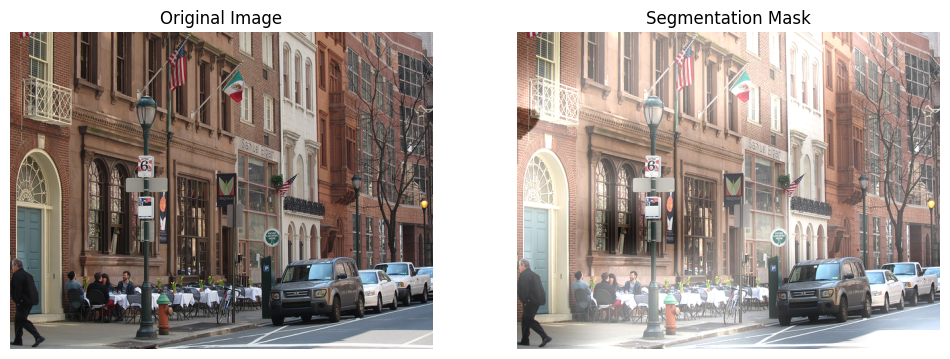

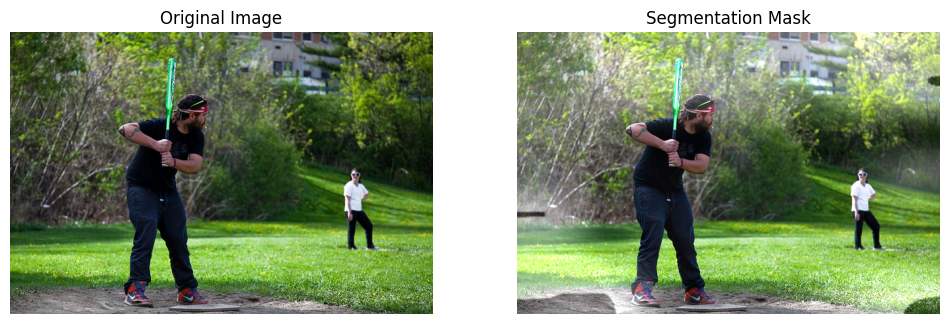

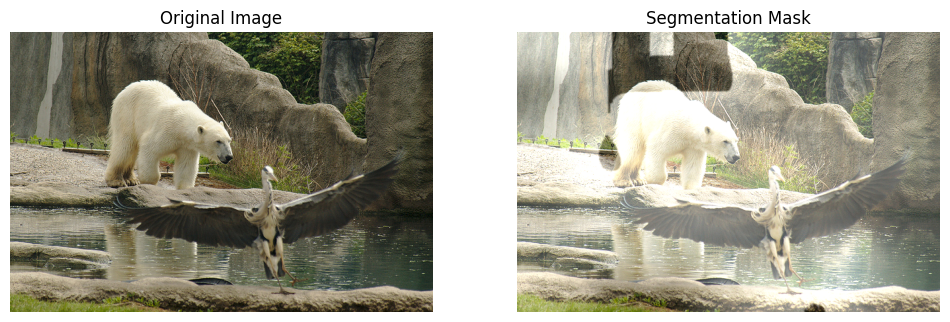

In [147]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2  # To use cv2 for blending

# Function to run segmentation on an image (DeepLabV3 or any other model)
def run_deeplab_segmentation(image_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))  # Resize to match model input size
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Load the pre-trained model (DeepLabV3 with MobileNetV2 or similar)
    model = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False)
    
    # Run segmentation model
    output = model(image_array)
    mask = output[0]  # Get the segmentation mask (first element of the output)
    
    # If the mask has more than one channel (e.g., for multi-class segmentation), select the class with the highest probability
    if len(mask.shape) > 2:  # In case it's multi-class (height x width x classes)
        mask = np.argmax(mask, axis=-1)  # Get the class with the highest probability
    mask = np.expand_dims(mask, axis=-1)  # Make it a single-channel mask
    
    return mask

# Function to visualize the original image and segmentation mask
def visualize_segmentation(image_path, mask):
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    
    # Resize the mask to the size of the original image
    mask_resized = Image.fromarray(mask.astype(np.uint8).squeeze())  # Remove extra dimensions
    mask_resized = mask_resized.resize(original_image.size)

    # Normalize the mask to [0, 255] and apply it as an overlay
    mask_resized = np.array(mask_resized)
    mask_resized = np.expand_dims(mask_resized, axis=-1)  # Add the extra channel dimension for RGB

    # Apply the mask as a colored overlay (using alpha blending)
    mask_colored = np.repeat(mask_resized, 3, axis=-1)  # Repeat the mask for R, G, B channels
    mask_colored = np.uint8(mask_colored * 255)  # Convert the mask into [0, 255] range

    # Apply a blur to the mask for smoother blending
    mask_colored = cv2.GaussianBlur(mask_colored, (5, 5), 0)

    # Overlay the mask on the original image (with some transparency)
    original_image_array = np.array(original_image)
    masked_image = cv2.addWeighted(original_image_array, 1, mask_colored, 0.5, 0)

    # Show the original image and the segmentation mask
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(masked_image)
    plt.title("Segmentation Mask")
    plt.axis('off')
    
    plt.show()

# Now, apply segmentation to the retrieved images from Cell 2
# Assuming `image_paths` are already retrieved from the `display_images_for_classes` function

for image_path in image_paths:
    mask = run_deeplab_segmentation(image_path)
    visualize_segmentation(image_path, mask)


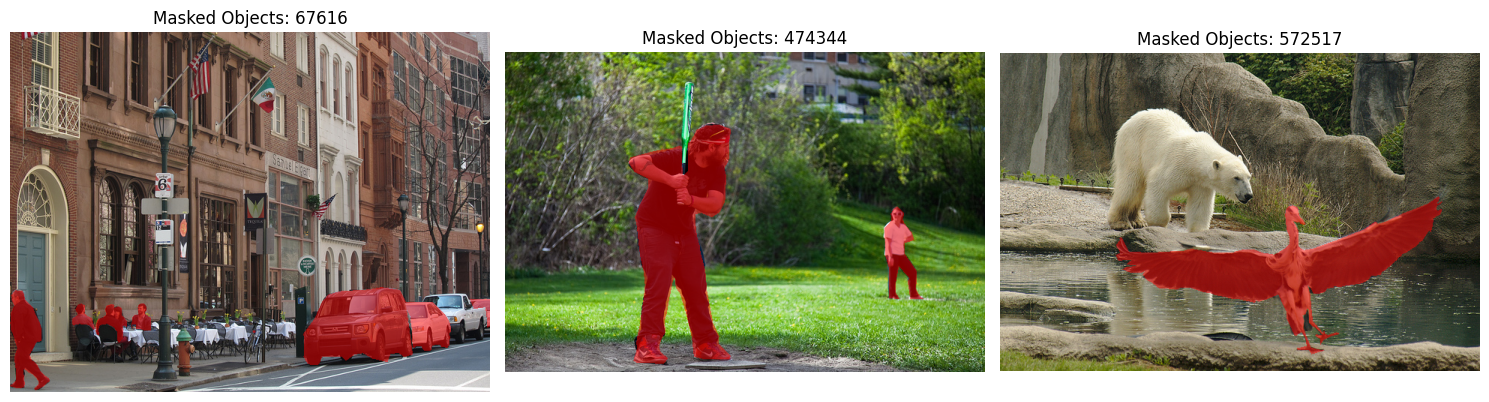

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import os

def generate_masks(image_paths, detected_classes, coco_instance):
    """
    Generate and display masks for the detected objects in the images, 
    only highlighting the regions inside the bounding boxes of detected objects.
    """
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    
    # Ensure axes is iterable even for single image
    if len(image_paths) == 1:
        axes = [axes]

    images_displayed = 0

    for img_path in image_paths:
        try:
            # Load image
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)

            # Extract the image ID from the path (assuming image ID is derived from filename)
            img_id = int(os.path.splitext(os.path.basename(img_path))[0].split('_')[-1])

            # Get annotations for the image
            ann_ids = coco_instance.getAnnIds(imgIds=[img_id])
            anns = coco_instance.loadAnns(ann_ids)

            # Initialize an empty mask (black background)
            mask = np.zeros(img_array.shape[:2], dtype=np.uint8)

            for ann in anns:
                category_name = coco_instance.loadCats([ann['category_id']])[0]['name']
                if category_name in detected_classes:
                    # Combine all masks for the detected objects (mask each object detected)
                    mask += coco_instance.annToMask(ann)

            # Clip the mask to ensure it stays binary (0 or 1)
            mask = np.clip(mask, 0, 1)

            # Create an overlay by blending the mask with the image (highlight the detected objects in red)
            overlay = img_array.copy()
            overlay[mask > 0] = [255, 0, 0]  # Highlight detected objects in red

            # Blend the original image with the overlay (masking applied to detected objects)
            blended = (0.5 * img_array + 0.5 * overlay).astype(np.uint8)

            # Display the original and blended image (segmented)
            axes[images_displayed].imshow(blended)
            axes[images_displayed].axis('off')
            axes[images_displayed].set_title(f"Masked Objects: {img_id}")
            images_displayed += 1

        except Exception as e:
            print(f"Error generating mask for image '{img_path}': {e}")

    if images_displayed > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("No images to display.")


# Generate and display masks
generate_masks(image_paths, detected_classes, coco)


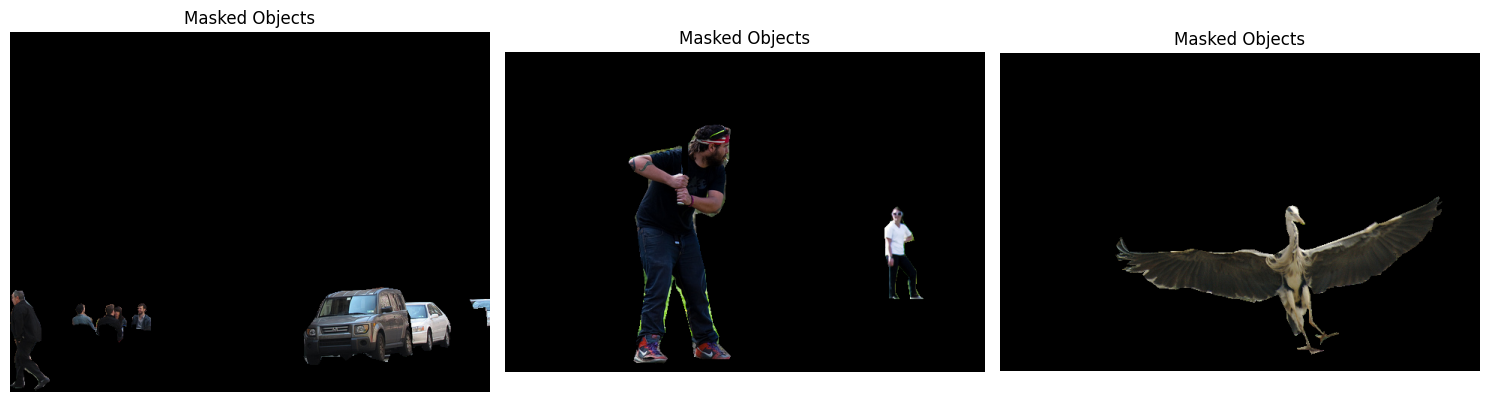

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import os

def generate_masks(image_paths, detected_classes, coco_instance):
    """
    Generate and return masks for the detected objects in the images, 
    only keeping the regions inside the bounding boxes of detected objects.
    """
    masked_images = []  # To store images with only the detected objects

    for img_path in image_paths:
        try:
            # Load image
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)

            # Extract the image ID from the path (assuming image ID is derived from filename)
            img_id = int(os.path.splitext(os.path.basename(img_path))[0].split('_')[-1])

            # Get annotations for the image
            ann_ids = coco_instance.getAnnIds(imgIds=[img_id])
            anns = coco_instance.loadAnns(ann_ids)

            # Initialize an empty mask (black background)
            mask = np.zeros(img_array.shape[:2], dtype=np.uint8)

            for ann in anns:
                category_name = coco_instance.loadCats([ann['category_id']])[0]['name']
                if category_name in detected_classes:
                    # Combine all masks for the detected objects (mask each object detected)
                    mask += coco_instance.annToMask(ann)

            # Clip the mask to ensure it stays binary (0 or 1)
            mask = np.clip(mask, 0, 1)

            # Apply the mask to the image (keeping only the detected objects)
            # Set non-masked regions to black (background removal)
            masked_image = img_array * np.expand_dims(mask, axis=-1)  # Apply mask to keep objects

            # Append the masked image to the list of masked images
            masked_images.append(masked_image)

        except Exception as e:
            print(f"Error generating mask for image '{img_path}': {e}")

    return masked_images


def display_masked_objects(masked_images):
    """
    Display the images with only the detected objects, showing the result.
    """
    fig, axes = plt.subplots(1, len(masked_images), figsize=(15, 5))

    # Ensure axes is iterable even for single image
    if len(masked_images) == 1:
        axes = [axes]

    images_displayed = 0
    for masked_image in masked_images:
        axes[images_displayed].imshow(masked_image)
        axes[images_displayed].axis('off')
        axes[images_displayed].set_title("Masked Objects")
        images_displayed += 1

    plt.tight_layout()
    plt.show()


# Example usage
# image_paths = ['image1.jpg', 'image2.jpg']  # Replace with your image paths
# detected_classes = ['person', 'car']  # Replace with your detected object classes
# coco = COCO(annotations_path)  # Initialize COCO instance with annotations

# Step 1: Generate masks for the detected objects in the images
masked_images = generate_masks(image_paths, detected_classes, coco)

# Step 2: Display the images with only the detected objects (background removed)
display_masked_objects(masked_images)


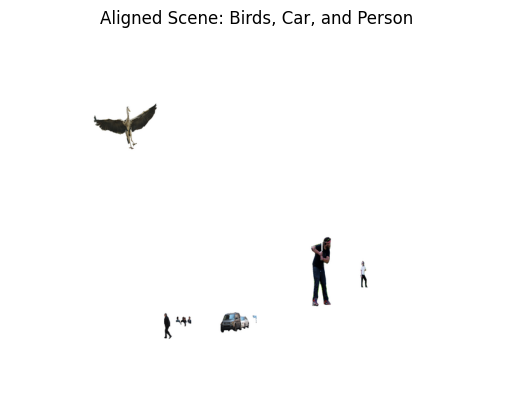

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Function to align masked objects based on the text description
def align_objects(masked_objects, detected_classes, relationships, image_size=(800, 600)):
    """
    Align the masked objects based on their relationships in the text.
    For example, 'Birds flying near the car' and 'Person walking on the street'.
    """
    # Create a blank canvas for the scene (white background)
    scene = Image.new("RGB", image_size, (255, 255, 255))

    # Predefined positions based on the scene description
    positions = {
        'bird': (100, 50),  # Birds flying near the top
        'car': (250, 350),  # Car near the bottom (on the street)
        'person': (450, 300)  # Person walking in the middle
    }

    # Loop over the detected classes and place each masked object on the canvas
    for i, obj_class in enumerate(detected_classes):
        # Get the corresponding masked object
        masked_image = masked_objects[i]
        
        if isinstance(masked_image, Image.Image):  # Check if it's a PIL.Image object
            # Resize the object to a fixed size (you can adjust this)
            size = (150, 150)  # Resize each object to fit the canvas
            resized_object = masked_image.resize(size, Image.Resampling.LANCZOS)

            # Get the position based on the predefined positions
            position = positions.get(obj_class, (100, 50))  # Default to (100, 50) if no position is found

            # Paste the resized object on the canvas (mask the object)
            scene.paste(resized_object, position, mask=resized_object.convert("RGBA").split()[3])

    return scene

def display_only_masked_objects(detected_classes, coco_instance, image_paths):
    """
    Display only the masked objects for each image, removing the background.
    This will return the masked images to be used in the final scene generation.
    """
    masked_images = []

    for img_path in image_paths:
        try:
            # Load the image
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)

            # Extract the image ID from the path
            img_id = int(os.path.splitext(os.path.basename(img_path))[0].split('_')[-1])

            # Get annotations for the image
            ann_ids = coco_instance.getAnnIds(imgIds=[img_id])
            anns = coco_instance.loadAnns(ann_ids)

            # Initialize an empty mask
            mask = np.zeros(img_array.shape[:2], dtype=np.uint8)

            for ann in anns:
                category_name = coco_instance.loadCats([ann['category_id']])[0]['name']
                if category_name in detected_classes:
                    # Create a binary mask for each object
                    mask += coco_instance.annToMask(ann)

            # Clip the mask to ensure binary values (0 or 1)
            mask = np.clip(mask, 0, 1)

            # Create a new image with only the detected objects
            masked_image = img_array.copy()
            masked_image[mask == 0] = 255  # Set background to white (or you can use another color)

            # Convert the masked image to a PIL Image and append to the list
            masked_images.append(Image.fromarray(masked_image))

        except Exception as e:
            print(f"Error displaying image for detected objects: {e}")

    return masked_images



# Assuming coco_instance is already defined (COCO instance with loaded annotations)
# Retrieve masked objects from the previously generated code
masked_objects = display_only_masked_objects(detected_classes, coco, image_paths)

# Relationships extracted from the text (for reference)
relationships = [('bird', 'fly', 'car'), ('person', 'walking', 'street')]

# Align the objects based on the scene description and relationships
aligned_scene = align_objects(masked_objects, detected_classes, relationships)

# Display the final aligned image
plt.imshow(aligned_scene)
plt.axis('off')
plt.title("Aligned Scene: Birds, Car, and Person")
plt.show()


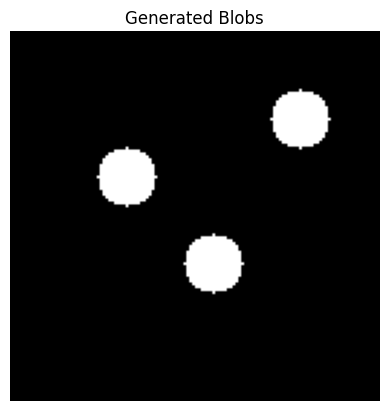

In [173]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_blobs(object_positions, canvas_size=(128, 128)):
    """
    Generate a canvas with white blobs at specified positions.

    Args:
        object_positions (list of tuples): List of (x, y) positions for blobs.
        canvas_size (tuple): Size of the canvas (height, width).

    Returns:
        np.ndarray: Canvas with blobs.
    """
    canvas = np.zeros(canvas_size, dtype=np.uint8)  # Black canvas
    radius = 10  # Radius of each blob

    for position in object_positions:
        cv2.circle(canvas, position, radius, 255, -1)  # Draw white blobs (255 for white)

    return canvas

# Example: Positions parsed from text (you can extract them using NLP)
object_positions = [(40, 50), (70, 80), (100, 30)]  # Example positions (x, y)

# Generate canvas with blobs
canvas = generate_blobs(object_positions)

# Display the canvas
plt.imshow(canvas, cmap='gray')
plt.title("Generated Blobs")
plt.axis("off")
plt.show()
